# MCMC Sampling

Markov chain monte Carlo Sampling

*Quickly* sample from any distribution.

## Advantages:
* Works with unnormalized denisty.
* Faster than other sampling methods (ex: rejection sampling)
* Easier to work with compared to rejction sampling (we had to choose appropriate g(x))

Let's suppose we wanted to sample from the density f(x). 

One method that we learnt is rejection sampling.

Recall the condition for rejection.


But we know, that if we got a point of high probability at a location, the points near it will also have a fair chance of having high probability.

In order to use this fact, we will 'engineer' a markov chain which has the stationary distribution $f(x)$.

An algorithm is the Metropolis Hastings algorithm which engineers such markov chains.


what is support?

The algorithm is following:

Start with initial point as some $x_i$ in the support of the $f(x)$.

Sample a proposal point $a$ from a distribution $g(X_{i+1}| X_i)$

accept the proposal with probability 
\begin{equation}
p = min(1, \frac{f(a)}{f(x_i)})
\end{equation}

i.e, 

if the proposal is accepted, set $x_{i+1} = a$

$x_{i+1} = x_{i}$ otherwise.

given that $g(X_{i+1}|X_i)$ satisfies some properties.

Ex: we should be able to go to every location starting from any location. etc.

one of the distribution that satisfies all these conditions is
\begin{equation}
g(X_{i+1}|X_i) = N(X_i,\sigma_{prop})
\end{equation}

If we use this as our proposal distribution, it is called *Random walk Metropolis-Hastings (RMH) algorithm*

Suppose we want to sample from a distribution that looks like this

![image-2.png](attachment:image-2.png)


![image.png](attachment:image.png)

Start with some initial point $X_i$ and sample a point $a$ from $N(X_i,\sigma)$. If it is uphill, accept it. 


![image.png](attachment:image.png)

If it is going downhill, it is accepted with probability $\frac{f(a)}{f(x_i}$

![image.png](attachment:image.png)

![image.png](attachment:image.png)

# Code

In [ ]:
import blackjax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import os

def rmh_inference_loop(dist_numerator,sigma_rmh,params,num_samples):
    rmh = blackjax.rmh(dist_numerator, sigma= sigma_rmh)
    # initial = jnp.array([10.4,11.4])
    initial_state = rmh.init(params)
    def inference_loop(rng_key, kernel, initial_state, num_samples):
        @jax.jit
        def one_step(state, rng_key):
            state, _ = kernel(rng_key, state)
            return state, state

        keys = jax.random.split(rng_key, num_samples)
        _, states = jax.lax.scan(one_step, initial_state, keys)

        return states
    rng_key = jax.random.PRNGKey(0)
    _, rng_key = jax.random.split(rng_key)
    states = inference_loop(rng_key, rmh.step, initial_state, num_samples)
    return states

def plot_rmh(states,burnin,contains_arrays=False):
    for key in states.position:
        if jnp.ndim(states.position[key])==1:
            fig, (ax,ax1) = plt.subplots(1,2,figsize=(13,5))
            ax.plot(states.position[key])
            ax.set_title('trace plot')
            ax.axvline(x=burnin, c="tab:red")
            ax1.hist(states.position[key],density=True)
            sns.kdeplot(states.position[key],ax=ax1)
            ax1.set_title("histogram")
            plt.suptitle(key,fontsize=20)
            try:
                plt.savefig('figures/'+key+'.jpeg')
            except:
                os.mkdir('figures')
                plt.savefig('figures/'+key+'.jpeg')
            plt.show()
        
        else:
            for i in range(states.position[key].shape[1]):
                fig, (ax,ax1) = plt.subplots(1,2,figsize=(8,3))
                ax.plot(states.position[key][:,i])
                ax.set_title('trace plot')
                ax.axvline(x=burnin, c="tab:red")
                ax1.hist(states.position[key][burnin:,i],density=True)
                sns.kdeplot(states.position[key][burnin:,i],ax=ax1)
                ax1.set_title("histogram")
                plt.suptitle(key+str(i),fontsize=20)
                try:
                    plt.savefig('figures/'+key+str(i)+'.jpeg')
                except:
                    os.mkdir('figures')
                    plt.savefig('figures/'+key+str(i)+'.jpeg')
                plt.show()


In [ ]:
import jax.numpy as jnp
import jax
import tensorflow_probability.substrates.jax as tfp


tfd = tfp.distributions

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse

import blackjax

In [ ]:
mu = jnp.array([[1.,0]])
sigma = jnp.array([[2.,0],[0,2.0]])

# Un-normailized  2-D Normal distribution.
def log_target(x):
    # use tfd here.
    # return (-(1/2)*((x-mu)@jnp.linalg.inv(sigma))@(x-mu).T)[0][0].astype(jnp.float32)
    norm = tfd.MultivariateNormalFullCovariance(mu,sigma)
    return norm.log_prob(x)[0]

In [ ]:
x = jnp.linspace(-7,7,50)
y = jnp.linspace(-7,7,50)
XX, YY = jnp.meshgrid(x,y)
likel = []
for i in range(XX.shape[0]):
    prob = []
    for j in range(XX.shape[1]):
        prob.append(jnp.exp(log_target(
            jnp.array([XX[i][j],YY[i][j]])
            )))
    likel.append(prob)

likel = jnp.array(likel)

In [ ]:
norm = tfd.MultivariateNormalFullCovariance(mu,sigma)
grid = jax.tree_map(lambda x,y: jnp.array([x,y]),XX,YY)
likel = jnp.exp(norm.prob(grid.T).T)

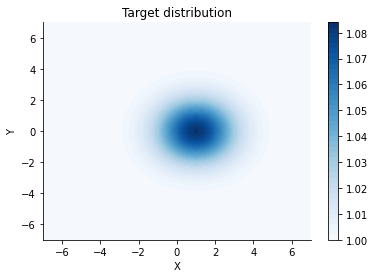

In [ ]:
fig, ax = plt.subplots(1, 1)
cs = ax.contourf(XX,YY,likel,50,cmap="Blues")
plt.xlabel("X")
plt.ylabel("Y")
sns.despine()
ax.set_title("Target distribution")
fig.colorbar(cs,ax = ax)

In [ ]:
norm = tfd.Normal(mu,1)
norm.prob(jnp.array([2.0,0.0])).prod()
# norm

DeviceArray(0.09653236, dtype=float32)

In [ ]:
sigma = jnp.identity(2)
multi_norm = tfd.MultivariateNormalFullCovariance(mu,sigma)
multi_norm.prob(jnp.array([[2.0,0.0]]))

DeviceArray([0.09653236], dtype=float32)

# The algorithm

In [ ]:
samples = [jnp.array([-3.,-3])]
num_accept = 0
num_samples = 1000
seed = jax.random.PRNGKey(1)
prop_width = 1.0
for _ in range(num_samples):
    
    #sample candidate from normal distribution
    proposal = tfd.Normal(samples[-1], prop_width)
    candidate = proposal.sample(seed= seed)
    seed, _ = jax.random.split(seed)
    
    #calculate probability of accepting this candidate
    prob = min(1, jnp.exp(log_target(candidate)) / jnp.exp(log_target(samples[-1])))
    
    #accept with the calculated probability
    if jax.random.uniform(seed) < prob:
        samples.append(candidate)
        num_accept += 1
    
    #otherwise report current sample again
    else:
        samples.append(samples[-1])

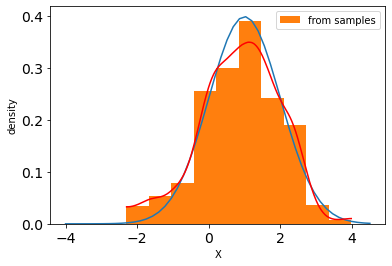

In [ ]:
import arviz as az

samples = jnp.array(samples)
burnin = 300
# show marginalized distribution here.
normal_marginalized = tfd.Normal(mu[0,0],jnp.sqrt(sigma[0,0]))
x_lin = jnp.linspace(-4,4.5)
plt.plot(x_lin,normal_marginalized.prob(x_lin))
plt.hist(samples[burnin:,0],density=True,label="from samples")
az.plot_dist(samples[burnin:,0],color="red")
plt.xlabel("X")
plt.ylabel("density")
plt.legend()

## Using blackjax's rmh

In [ ]:
prop_width = jnp.array([1.,1.0])
# we are sampling 2 variables here, so the length of array prop
# width should be 2

rmh = blackjax.rmh(log_target, sigma= prop_width)
initial = jnp.array([[-3.0,-3]])
initial_state = rmh.init(initial)

In [ ]:
initial_state

RMHState(position=DeviceArray([[-3., -3.]], dtype=float32), log_probability=DeviceArray(-14.337877, dtype=float32))

In [ ]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state,info)
    
    keys = jax.random.split(rng_key, num_samples)
    _, info = jax.lax.scan(one_step, initial_state, keys)
    return info

In [ ]:
rng_key = jax.random.PRNGKey(0)
num_samples = 1000
states,infos = inference_loop(rng_key, rmh.step, initial_state, num_samples)

(-6.0, 6.0)

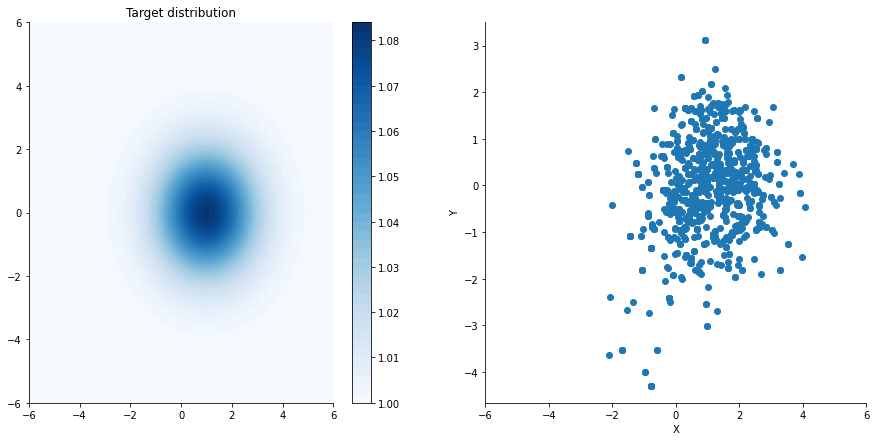

In [ ]:
fig, (ax,ax1) = plt.subplots(1, 2,figsize=(15,7))
cs = ax.contourf(XX,YY,likel,50,cmap="Blues")
plt.xlabel("X")
plt.ylabel("Y")
sns.despine()
ax.set_title("Target distribution")
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)

fig.colorbar(cs,ax = ax)
ax1.scatter(states.position[:,:,0].reshape(-1),states.position[:,:,1].reshape(-1))
ax1.set_xlim(-6,6)
ax.set_ylim(-6,6)

In [ ]:
infos.is_accepted.sum()/num_samples

DeviceArray(0.666, dtype=float32)

In [ ]:
def plot_rmh(states,burnin):
    for i in range(states.position.shape[2]):
    
        fig, (ax,ax1) = plt.subplots(1,2,figsize=(8,3))
        ax.plot(states.position[:,:,i])
        ax.set_title('trace plot')
        ax.axvline(x=burnin, c="tab:red")
        ax1.hist(states.position[burnin:,:,i].reshape(-1),density=True)
        sns.kdeplot(states.position[burnin:,:,i].reshape(-1),ax=ax1)
        ax1.set_title("histogram")
        plt.suptitle(str(i),fontsize=20)
        try:
            plt.savefig('figures/'+str(i)+'.jpeg')
        except:
            os.mkdir('figures')
            plt.savefig('figures/'+str(i)+'.jpeg')
        plt.show()



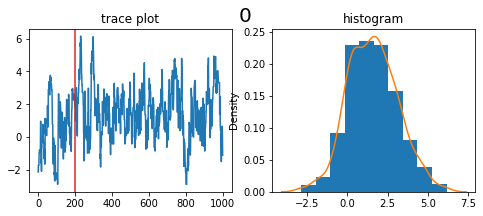

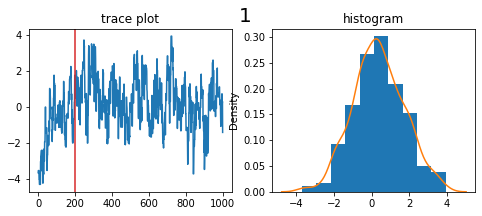

In [ ]:
plot_rmh(states,200)

In [ ]:
proposal_width = jnp.array([0.1,0.1])
num_samples = 1000
rmh = blackjax.rmh(dist_numerator, sigma= proposal_width)
initial = jnp.array([[-3.0,-3]])
initial_state = rmh.init(initial)

states_low_sigma,infos_low_sigma = inference_loop(rng_key, rmh.step, initial_state, num_samples)

In [ ]:
print("fraction acceptance")
infos_low_sigma.is_accepted.sum()/num_samples

fraction acceptance


DeviceArray(0.96, dtype=float32)

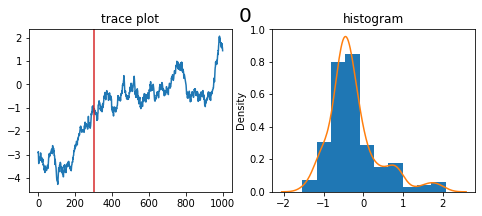

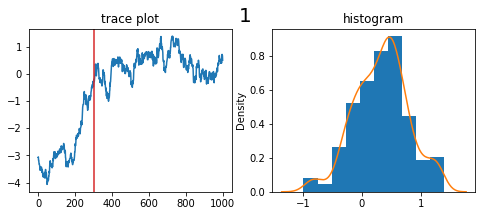

In [ ]:
plot_rmh(states_low_sigma,burnin=300)

In [ ]:
proposal_width = jnp.array([10,10])
num_samples = 1000
rmh = blackjax.rmh(dist_numerator, sigma= proposal_width)
initial = jnp.array([[-3.0,-3]])
initial_state = rmh.init(initial)

states_high_sigma,infos_high_sigma = inference_loop(rng_key, rmh.step, initial_state, num_samples)

In [ ]:
infos_high_sigma.is_accepted.sum()/num_samples

DeviceArray(0.048, dtype=float32)

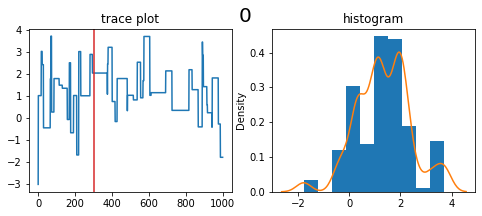

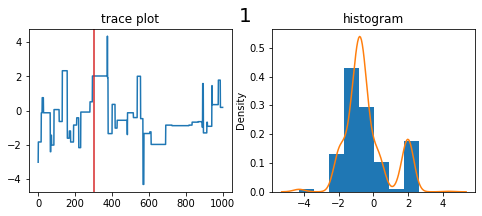

In [ ]:
plot_rmh(states_high_sigma,300)

In [ ]:
x = jnp.linspace(-7,7,50)
y = jnp.linspace(-7,7,50)
XX, YY = jnp.meshgrid(x,y)
likel = []
for i in range(XX.shape[0]):
    prob = []
    for j in range(XX.shape[1]):
        prob.append(jnp.exp(log_target(
            jnp.array([XX[i][j],YY[i][j]])
            )))
    likel.append(prob)

likel = jnp.array(likel)


In [ ]:
grid = jax.tree_map(lambda x,y: (jnp.array([[x,y]])), XX, YY).reshape(2,XX.shape[0],XX.shape[1])
normal = tfd.MultivariateNormalFullCovariance(mu.astype(jnp.float32),jnp.sqrt(sigma))

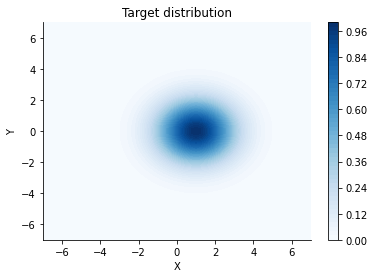

In [ ]:
color = {True:"green",False:"red"}

In [ ]:
!mkdir figures_prob

In [ ]:
for i in range(100):
    x_cur = states.position[i-1,0,0]
    y_cur = states.position[i-1,0,1]
    x_prop = infos.proposal[0][i,0,0]
    y_prop = infos.proposal[0][i,0,1]
    fig, ax = plt.subplots(1, 1)
    cs = ax.contourf(XX,YY,likel,50,cmap="Blues")
    ax.scatter(x_cur,y_cur,c='black',label='current')
    ell = Ellipse( (x_cur, y_cur ),
                    2*1.65*sigma_rmh[0] , 2*1.65*sigma_rmh[1],
                    fill = False ,alpha=0.5,color='orange')
    ax.add_artist(ell)
    dx = infos.proposal[0][i,0,0] - states.position[i-1,0,0] 
    dy = infos.proposal[0][i,0,1] - states.position[i-1,0,1] 
    plt.arrow(states.position[i-1,0,0],states.position[i-1,0,1],dx,dy,head_width=0.2,length_includes_head = True)
    ax.scatter(infos.proposal[0][i,0,0],infos.proposal[0][i,0,1],c=color[bool(infos.is_accepted[i])],label= 'proposed')
    ax.scatter(states.position[:i-1,0,0],states.position[:i-1,0,1],s=3,alpha=0.5,label='accepted')
    ax.legend(loc=1)
    sns.despine()
    ax.set_title(f"RMH sampling p={infos.acceptance_probability[i]}")
    fig.colorbar(cs,ax = ax)
    plt.savefig("figures_prob/"+str(40000+i))
    plt.close(fig)

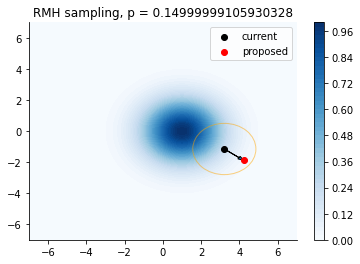

In [ ]:
i = 121
x_cur = states.position[i-1,0,0]
y_cur = states.position[i-1,0,1]
x_prop = infos.proposal[0][i,0,0]
y_prop = infos.proposal[0][i,0,1]
fig, ax = plt.subplots(1, 1)
cs = ax.contourf(XX,YY,likel,50,cmap="Blues")
ax.scatter(x_cur,y_cur,c='black',label='current')
ell = Ellipse( (x_cur, y_cur ),
                2*1.65*sigma_rmh[0] , 2*1.65*sigma_rmh[1],
                fill = False ,alpha=0.5,color='orange')
ax.add_artist(ell)
dx = infos.proposal[0][i,0,0] - states.position[i-1,0,0] 
dy = infos.proposal[0][i,0,1] - states.position[i-1,0,1] 
plt.arrow(states.position[i-1,0,0],states.position[i-1,0,1],dx,dy,head_width=0.2,length_includes_head = True)
ax.scatter(infos.proposal[0][i,0,0],infos.proposal[0][i,0,1],c=color[bool(infos.is_accepted[i])],label= 'proposed')
# ax.scatter(infos.proposal[0][i,0,0],infos.proposal[0][i,0,1],c="orange",label= 'proposed')

# ax.scatter(states.position[:i-1,0,0],states.position[:i-1,0,1],s=3,alpha=0.5,label='accepted')
ax.legend()
sns.despine()
p = jnp.round(infos.acceptance_probability[i],2)
ax.set_title(f"RMH sampling, p = {p}")
fig.colorbar(cs,ax = ax)
plt.savefig("figures/"+str(i))
# plt.close(fig)

In [ ]:
p = jnp.round(infos.acceptance_probability[i],2)
p

DeviceArray(0.28, dtype=float32)

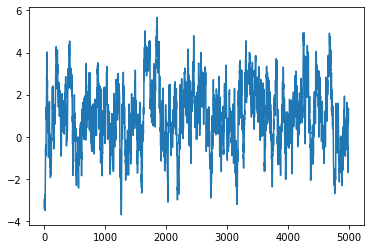

In [ ]:
plt.plot(states.position[:,:,0].reshape(-1))

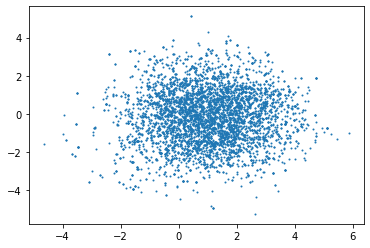

In [ ]:
plt.scatter(states.position[:,:,0].reshape(-1),states.position[:,:,1].reshape(-1),s=1)

In [ ]:
infos.proposal[0].shape

(500, 1, 2)

# Linear regression

In [ ]:
# import libraries
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import matplotlib.pyplot as plt
import pickle
import logging
from rmh import rmh_inference_loop,plot_rmh
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
key = jax.random.PRNGKey(5)

# MCMC for Linear regression with normal distribution

In [ ]:
# import libraries
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import matplotlib.pyplot as plt
import pickle
import logging
from rmh import rmh_inference_loop,plot_rmh
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
key = jax.random.PRNGKey(5)

Lets generate samples now.

In [ ]:
data = {'data': {'x': jnp.array([[ 1.7598495 ],
         [-0.23643708],
         [ 3.1509051 ],
         [-0.79705334],
         [-2.500547  ],
         [ 1.6101036 ],
         [ 0.14806175],
         [ 0.05331182],
         [ 2.6665907 ],
         [-0.14456654]]),
  'y': jnp.array([[ 9.011515 ],
         [ 5.4843464],
         [ 9.670069 ],
         [ 1.1274505],
         [-1.283633 ],
         [ 7.062801 ],
         [ 3.6567392],
         [ 2.2533112],
         [10.321623 ],
         [ 2.2750926]])},
 'noise_variance': 1,
 'prior': {'mean': jnp.array([14. ,  7.3]),
  'var': jnp.array([[10.,  0.],
         [ 0., 10.]]),
  'alpha': 1,
  'beta': 1}}

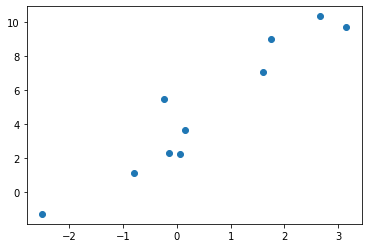

In [ ]:
# with open("linear_regression",'rb') as f:
#     data = pickle.load(f)
x = jnp.array(data['data']['x'])
def identity_trans(x):
    return jnp.append(jnp.ones((x.shape[0],1)),x,axis=1)
m = x.shape[0]
x_trans = identity_trans(x)
y = jnp.array(data['data']['y'])
prior_mean = jnp.array(data['prior']['mean'])
prior_var = jnp.array(data['prior']['var'])
noise_var = data['noise_variance']
plt.scatter(x,y)

$y = mx + c$

parameters m,c

In [ ]:
def create_log_postfn(x_trans,y,prior_mean,prior_var):
  n = x_trans.shape[1]
  prior_normal = tfd.MultivariateNormalFullCovariance(
      loc = prior_mean,covariance_matrix= prior_var
  )
  y = y.reshape(m,)

  def log_postfn(theta):
    # from the above equation
    # log_prior = -(x/lamda)**k+ (k-1)*(jnp.log(x)-jnp.log(lamda)) +jnp.log(k/lamda)
    theta = theta['theta']
    log_prior = prior_normal.log_prob(theta)
    # log_likelihood
    mean = (x_trans@theta.reshape(n,1)).reshape(m,)
    likelihood_normal = tfd.MultivariateNormalFullCovariance(mean,jnp.identity(m))
    log_like = jnp.array(likelihood_normal.log_prob(y))
    return (log_like+log_prior)
    
  return log_postfn
log_postfn = create_log_postfn(x_trans,y,prior_mean,prior_var)

RMH here stands for Random walk Metropolis Hastings.
We will use the blackjax implementation of it.

Things we have to do using jax


*   rmh takes the log of posterior pdf and sigma is the walk length parameter. So give them.
*   Then define the initial state of the rmh. This is done by just giving the initial value of whatever we are trying to estimate.




In [ ]:
prior_mean, prior_var

(DeviceArray([14. ,  7.3], dtype=float32),
 DeviceArray([[10.,  0.],
              [ 0., 10.]], dtype=float32))

In [ ]:
initial = {"theta":(prior_mean)}

Lets generate samples from posterior distribution now.

lets now see how it is varying. As we can see from the below figure, the parameter is changing a lot durin the first 300 iterations and then having a stationary distribution. So we eliminate the first 300 samples and then just take a target distribution as the emperical distribution of the samples.

In [ ]:
n = 2
states = rmh_inference_loop(log_postfn,jnp.identity(n) * 0.7,initial,20_000)

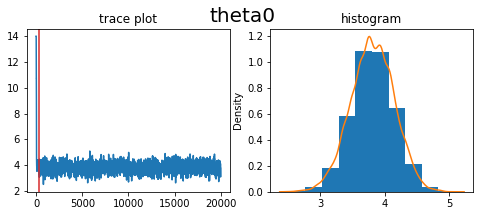

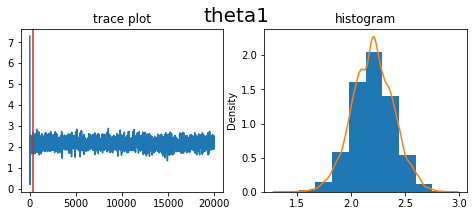

In [ ]:
burnin = 300
plot_rmh(states,burnin,contains_arrays=True)

In [ ]:
def posterior(phi,m_0, t, S_0, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = jnp.linalg.inv(S_0) + beta * phi.T.dot(phi)
    S_N = jnp.linalg.inv(S_N_inv)
    # print(S_N.shape,m_0.shape)
    m_N =S_N@(jnp.linalg.inv(S_0)@m_0+beta *phi.T.dot(t))

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

In [ ]:
mean,cov = posterior(x_trans, prior_mean.reshape((-1,1)), y.reshape((-1,1)), prior_var,1)

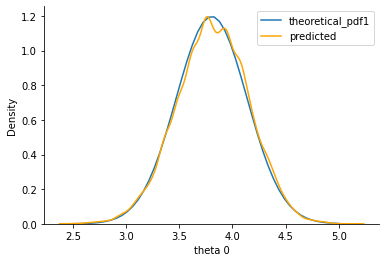

In [ ]:
import arviz as az
import seaborn as sns
x_lin_param0 = jnp.linspace(2.5,5)
true_normal1 = tfd.Normal(mean[0],jnp.sqrt(cov[0,0]))
theoretical_pdf1 = true_normal1.prob(x_lin_param0)
plt.plot(x_lin_param0,theoretical_pdf1,label='theoretical_pdf1')
sns.kdeplot(states.position['theta'][burnin:,0],label="predicted",color='orange')
# az.plot_dist(states.position['theta'][burnin:,0],label="predicted",color='red')
sns.despine()
plt.xlabel('theta 0')
plt.legend()

$y = N(\theta_i^TX,\sigma)$

I am sampling from this distribution as y.

In [ ]:
seed = jax.random.PRNGKey(5)


def predict_mcmc(seed,x_test):
    sample_from_each = 10
    def one_step(carry, state):
        theta = state.position['theta']
        mean = (x_test@theta.reshape(n,1)).reshape(x_test.shape[0],)
        likelihood_normal = tfd.MultivariateNormalFullCovariance(mean,jnp.identity(x_test.shape[0]))
        y = likelihood_normal.sample(seed=carry,sample_shape=sample_from_each)
        carry,_ = jax.random.split(seed)
        return carry, y

    _, y_stacks = jax.lax.scan(one_step, seed, states)
    y_stacks = y_stacks.reshape(-1,x_test.shape[0])


    mean = y_stacks.mean(axis=0)
    std_dev = y_stacks.std(axis=0)
    return mean, std_dev


# mcmc_pred_mean, mcmc_pred_sigma = mcmc_pred_mean.reshape(xx.shape), mcmc_pred_sigma.reshape(xx.shape)

In [ ]:
x_linspace = jnp.linspace(-10,10,100)
x_trans_linspace = identity_trans(x_linspace.reshape((-1,1)))
mcmc_pred_mean, mcmc_pred_sigma = predict_mcmc(seed,x_trans_linspace)

In [ ]:
x_linspace.shape

(100,)

In [ ]:
mcmc_pred_mean.shape

(100,)

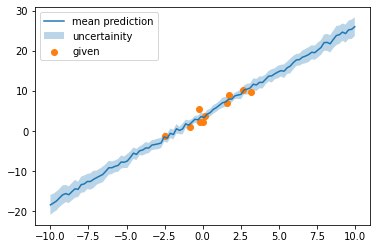

In [ ]:
plt.plot(x_linspace,mcmc_pred_mean,label="mean prediction")
plt.fill_between(x_linspace,mcmc_pred_mean+mcmc_pred_sigma,mcmc_pred_mean-mcmc_pred_sigma,alpha=0.3,label="uncertainity")
plt.scatter(data['data']['x'],jnp.array(data['data']['y']),label='given')
plt.legend()

In [ ]:
from pandas import to_pickle
to_pickle(states,"../results/linear_regression/results_data/MCMC_Blackjax")

Further reading

Mathematical Monk -- https://www.youtube.com/watch?v=12eZWG0Z5gY